In [342]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imblearn

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier

from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [343]:
# from google.colab import drive
# drive.mount('/content/drive')

In [344]:
df = pd.read_csv("processed_cleveland_data.csv", na_values='?')
df.drop(columns=['index'], inplace=True)

In [345]:
info = ["age","1: male, 0: female","chest pain type, 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic","resting blood pressure"," serum cholestoral in mg/dl","fasting blood sugar > 120 mg/dl","resting electrocardiographic results (values 0,1,2)"," maximum heart rate achieved","exercise induced angina","oldpeak = ST depression induced by exercise relative to rest","the slope of the peak exercise ST segment","number of major vessels (0-3) colored by flourosopy","thal: 3 = normal; 6 = fixed defect; 7 = reversable defect"]

for i in range(len(info)):
    print(df.columns[i]+":\t\t\t"+info[i])

age:			age
sex:			1: male, 0: female
cp:			chest pain type, 1: typical angina, 2: atypical angina, 3: non-anginal pain, 4: asymptomatic
trestbps:			resting blood pressure
chol:			 serum cholestoral in mg/dl
fbs:			fasting blood sugar > 120 mg/dl
restecg:			resting electrocardiographic results (values 0,1,2)
thalach:			 maximum heart rate achieved
exang:			exercise induced angina
oldpeak:			oldpeak = ST depression induced by exercise relative to rest
slope:			the slope of the peak exercise ST segment
ca:			number of major vessels (0-3) colored by flourosopy
thal:			thal: 3 = normal; 6 = fixed defect; 7 = reversable defect


In [346]:
for column in df.columns:
    if df[column].isna().sum() > 0:
        mode_value = df[column].mode(dropna=True)
        if not mode_value.empty:
            df[column].fillna(mode_value[0], inplace=True)

df['ca'] = pd.to_numeric(df['ca'], errors='coerce')
df['thal'] = pd.to_numeric(df['thal'], errors='coerce')

target_column = "target"

numerical_cols = df.drop(columns=[target_column]).select_dtypes(include=['number']).columns

scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

C:\Users\noels\AppData\Local\Temp\ipykernel_27816\1460245824.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[column].fillna(mode_value[0], inplace=True)


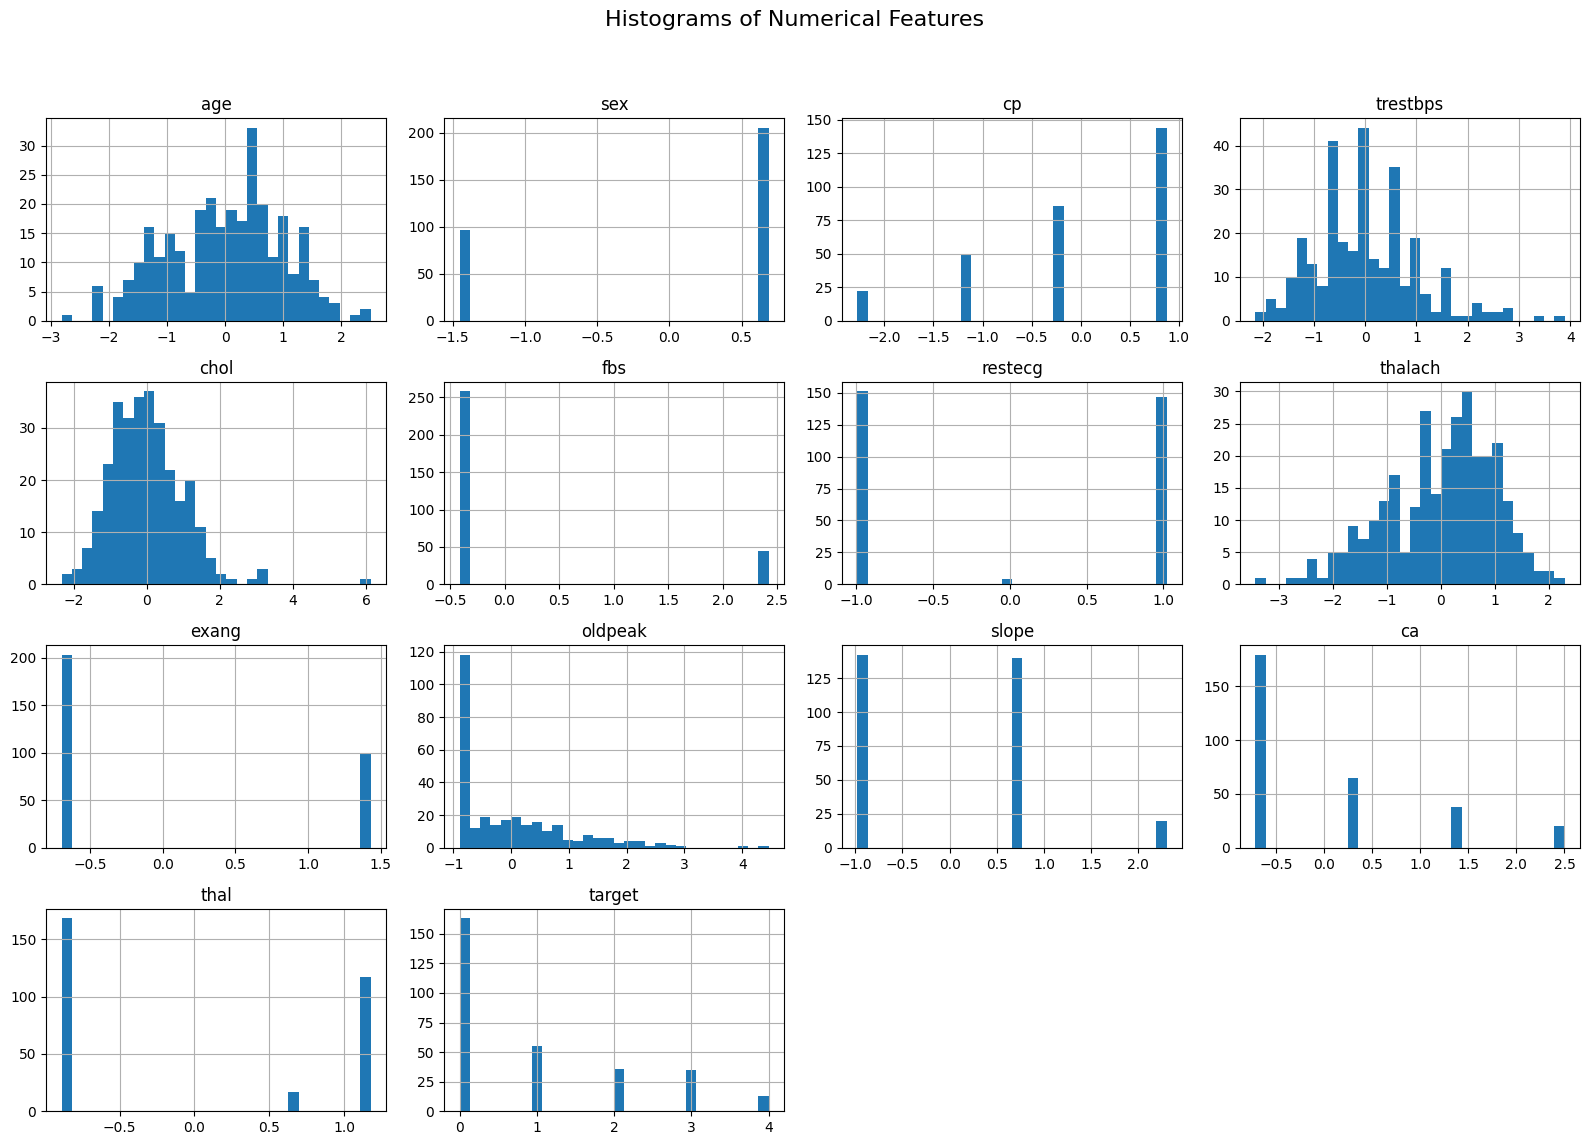

In [347]:
df.hist(figsize=(16, 12), bins=30)
plt.suptitle("Histograms of Numerical Features", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [348]:
print(df.corr()["target"].abs().sort_values(ascending=False))

target      1.000000
ca          0.520107
thal        0.509685
oldpeak     0.508330
thalach     0.415399
cp          0.405182
exang       0.395996
slope       0.387417
sex         0.226601
age         0.225809
restecg     0.186769
trestbps    0.159978
chol        0.070315
fbs         0.065937
Name: target, dtype: float64


In [349]:
X = df.drop(columns=[target_column])
y = df[target_column]

In [350]:
def preprocess_data(X, y, target_column, test_size=0.2, random_state=42):
    print("Before SMOTE:", Counter(y))
    X, y = SMOTE().fit_resample(X, y)
    print("After SMOTE:", Counter(y))
    
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)

In [351]:
# X = df.drop(columns=[target_column])
# y = df[target_column]
# print("Before SMOTE")
# counter = Counter(y)
# print(counter)
# oversample = SMOTE()
# X, y = oversample.fit_resample(X, y)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# print("After SMOTE")
# counter = Counter(y)
# print(counter)

In [352]:
num_classes = len(np.unique(y_train))
def create_dnn_model(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='sparse_categorical_crossentropy',   # ✅ sparse
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [353]:
def get_models(input_dim, num_classes):
    models = {
        "Logistic Regression": LogisticRegression(class_weight='balanced', max_iter=200),
        "Naive Bayes": GaussianNB(),
        "Support Vector Machine": svm.SVC(kernel='linear'),
        "Decision Tree": DecisionTreeClassifier(class_weight='balanced'),
        "Random Forest": RandomForestClassifier(class_weight='balanced', n_estimators=100),
        "XGBoost": XGBClassifier(eval_metric='mlogloss'),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, learning_rate=0.1),
        "Deep Neural Networks": create_dnn_model(input_dim, num_classes)
    }
    return models

In [354]:
# logreg = LogisticRegression(class_weight='balanced', max_iter=200)
# nb = GaussianNB()
# sv = svm.SVC(kernel='linear')
# dt = DecisionTreeClassifier(class_weight='balanced')
# rf = RandomForestClassifier(class_weight='balanced', n_estimators=100)
# xgb = XGBClassifier(eval_metric='mlogloss')
# knn = KNeighborsClassifier(n_neighbors=5)
# gbm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1)
# dnn = create_dnn_model(X_train.shape[1], num_classes)

In [355]:
def train_and_predict(models, X_train, y_train, X_test, epochs=50, batch_size=16):
    predictions = {}
    for name, model in models.items():
        if name == "Deep Neural Networks":
            model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      verbose=0, validation_split=0.2)
            predictions[name] = np.argmax(model.predict(X_test), axis=1)
        else:
            model.fit(X_train, y_train)
            predictions[name] = model.predict(X_test)
    return predictions

In [356]:
# logreg.fit(X_train, y_train)
# nb.fit(X_train,y_train)
# sv.fit(X_train, y_train)
# dt.fit(X_train, y_train)
# rf.fit(X_train, y_train)
# xgb.fit(X_train, y_train)
# knn.fit(X_train, y_train)
# gbm.fit(X_train, y_train)
# dnn.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_split=0.2)

In [ ]:
# y_pred_logreg = logreg.predict(X_test)
# y_pred_nb = nb.predict(X_test)
# y_pred_sv = sv.predict(X_test)
# y_pred_dt = dt.predict(X_test)
# y_pred_rf = rf.predict(X_test)
# y_pred_xgb = xgb.predict(X_test)
# y_pred_knn = knn.predict(X_test)
# y_pred_gbm = gbm.predict(X_test)
# y_pred_dnn = np.argmax(dnn.predict(X_test), axis=1)

In [ ]:
def evaluate_models(y_test, predictions):
    results = {
        "Model": [],
        "Accuracy": [],
        "Precision": [],
        "Recall": [],
        "F1 Score": []
    }
    
    for name, y_pred in predictions.items():
        results["Model"].append(name)
        results["Accuracy"].append(accuracy_score(y_test, y_pred))
        results["Precision"].append(precision_score(y_test, y_pred, zero_division=0, average='weighted'))
        results["Recall"].append(recall_score(y_test, y_pred, zero_division=0, average='weighted'))
        results["F1 Score"].append(f1_score(y_test, y_pred, zero_division=0, average='weighted'))
    
    return pd.DataFrame(results)


In [359]:
# model_names = ["Logistic Regression", "Naive Bayes", "Support Vector Machine", "Decision Tree", "Random Forest", "XGBoost", "KNN", "Gradient Boosting","Deep Neural Networks"]
# y_preds = [y_pred_logreg, y_pred_nb, y_pred_sv, y_pred_dt, y_pred_rf, y_pred_xgb, y_pred_knn, y_pred_gbm, y_pred_dnn]

# performance_data = {
#     "Model": [],
#     "Accuracy": [],
#     "Precision": [],
#     "Recall": [],
#     "F1 Score": []
# }

# for name, y_pred in zip(model_names, y_preds):
#     performance_data["Model"].append(name)
#     performance_data["Accuracy"].append(accuracy_score(y_test, y_pred))
#     performance_data["Precision"].append(precision_score(y_test, y_pred, zero_division=0, average='weighted'))
#     performance_data["Recall"].append(recall_score(y_test, y_pred, zero_division=0, average='weighted'))
#     performance_data["F1 Score"].append(f1_score(y_test, y_pred, zero_division=0, average='weighted'))


# df_results = pd.DataFrame(performance_data)

# print("\nModel Performance Summary:")
# print(df_results)

In [360]:
def run_pipeline(X,y, target_column):
    X_train, X_test, y_train, y_test = preprocess_data(X , y, target_column)
    num_classes = len(np.unique(y_train))
    models = get_models(X_train.shape[1], num_classes)
    predictions = train_and_predict(models, X_train, y_train, X_test)
    df_results = evaluate_models(y_test, predictions)
    print("\nModel Performance Summary:")
    print(df_results)
    return df_results, models

In [361]:
results, trained_models = run_pipeline(X, y, target_column="target")

Before SMOTE: Counter({0: 163, 1: 55, 2: 36, 3: 35, 4: 13})
After SMOTE: Counter({2: 163, 1: 163, 0: 163, 3: 163, 4: 163})


c:\Noel\codeProjects\CAD\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Model Performance Summary:
                    Model  Accuracy  Precision    Recall  F1 Score
0     Logistic Regression  0.533742   0.526119  0.533742  0.511121
1             Naive Bayes  0.539877   0.543010  0.539877  0.522770
2  Support Vector Machine  0.607362   0.606888  0.607362  0.599354
3           Decision Tree  0.711656   0.724285  0.711656  0.711898
4           Random Forest  0.895706   0.897309  0.895706  0.895521
5                 XGBoost  0.858896   0.863083  0.858896  0.856587
6                     KNN  0.840491   0.847191  0.840491  0.838572
7       Gradient Boosting  0.834356   0.835725  0.834356  0.833822
8    Deep Neural Networks  0.871166   0.871656  0.871166  0.870831


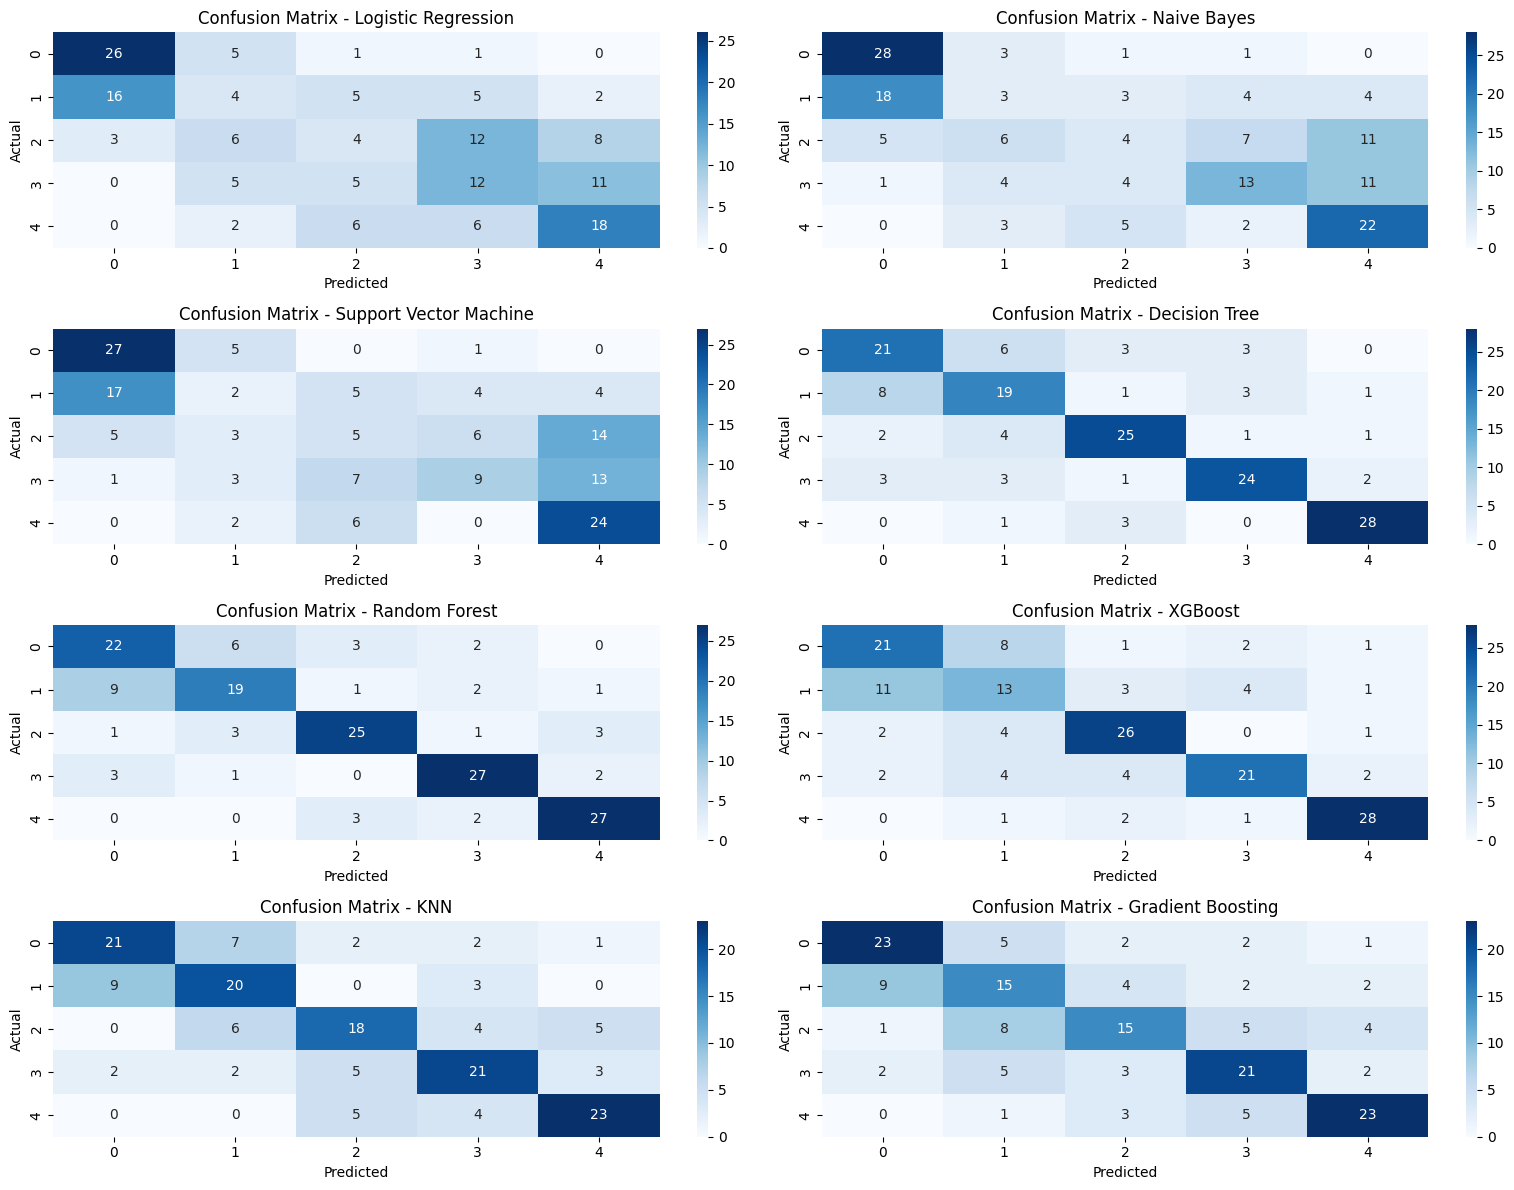

In [373]:
predictions = {
    'Logistic Regression': y_pred_logreg,
    'Naive Bayes': y_pred_nb,
    'Support Vector Machine': y_pred_sv,
    'Decision Tree': y_pred_dt,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'KNN': y_pred_knn,
    'Gradient Boosting': y_pred_gbm
}


class_labels = le_target.classes_ if 'le_target' in locals() and le_target else ['0', '1', '2', '3', '4']

plt.figure(figsize=(16, 12))

for i, (name, preds) in enumerate(predictions.items(), 1):
    cm = confusion_matrix(y_test, preds)
    plt.subplot(4, 2, i)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

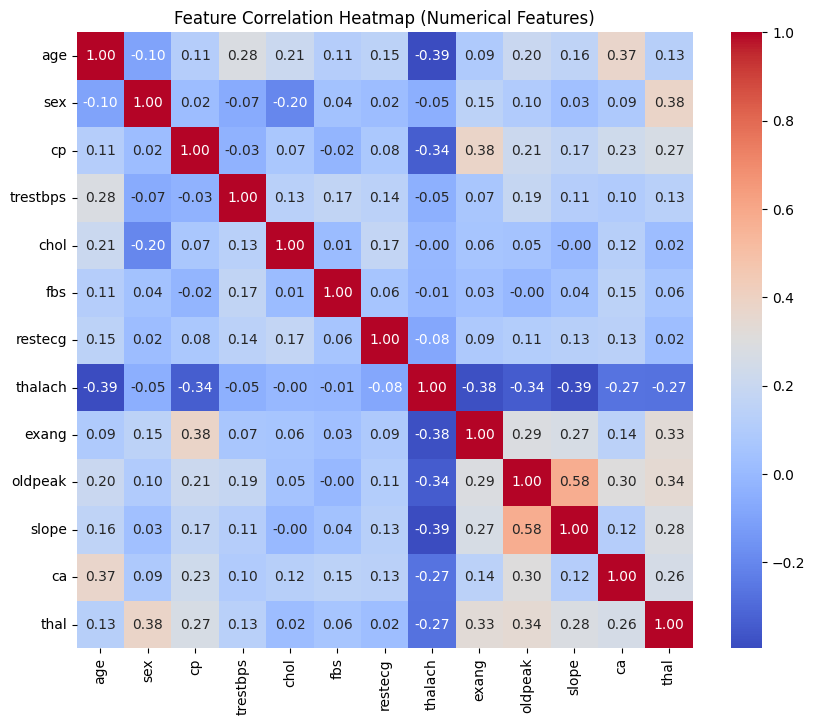

In [363]:
numerical_features_in_df = df.select_dtypes(include=['number']).columns.tolist()

if 'target' in numerical_features_in_df:
     numerical_features_in_df.remove('target')

plt.figure(figsize=(10, 8))
corr = df[numerical_features_in_df].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title("Feature Correlation Heatmap (Numerical Features)")
plt.show()

In [364]:
def transform_outliers_iqr(df, numerical_cols):
    df_transformed = df.copy()
    for col in numerical_cols:
        Q1 = df_transformed[col].quantile(0.25)
        Q3 = df_transformed[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR


        df_transformed[col] = df_transformed[col].clip(lower=lower_bound, upper=upper_bound)

    return df_transformed
print(f"Original dataset size: {df.shape[0]}")
df = transform_outliers_iqr(df, numerical_cols)
print(f"Dataset size after transforming outliers: {df.shape[0]}")

Original dataset size: 302
Dataset size after transforming outliers: 302


In [365]:
X = df.drop(columns=[target_column])
y = df[target_column]
results, trained_models = run_pipeline(X, y, target_column="target")

Before SMOTE: Counter({0: 163, 1: 55, 2: 36, 3: 35, 4: 13})
After SMOTE: Counter({2: 163, 1: 163, 0: 163, 3: 163, 4: 163})


c:\Noel\codeProjects\CAD\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Model Performance Summary:
                    Model  Accuracy  Precision    Recall  F1 Score
0     Logistic Regression  0.546012   0.546847  0.546012  0.543602
1             Naive Bayes  0.564417   0.581288  0.564417  0.558463
2  Support Vector Machine  0.582822   0.571857  0.582822  0.570417
3           Decision Tree  0.693252   0.688528  0.693252  0.688072
4           Random Forest  0.883436   0.883931  0.883436  0.883002
5                 XGBoost  0.883436   0.886090  0.883436  0.882612
6                     KNN  0.834356   0.835286  0.834356  0.832925
7       Gradient Boosting  0.779141   0.788401  0.779141  0.779864
8    Deep Neural Networks  0.865031   0.865290  0.865031  0.863631


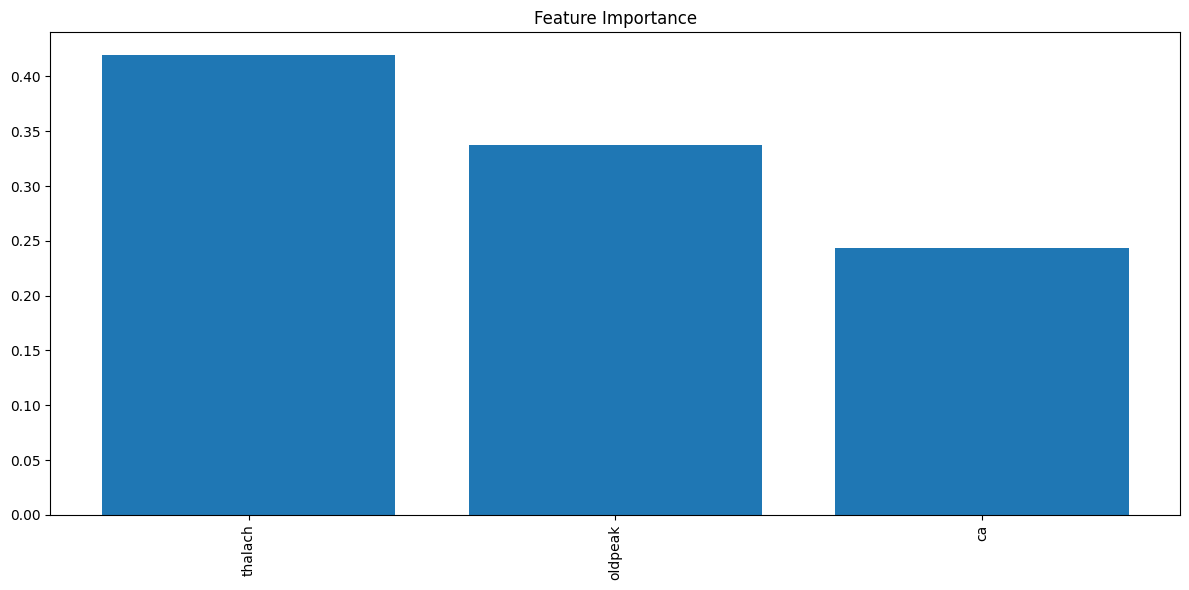

In [366]:
model = rf

importances = model.feature_importances_
features = X_train.columns

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[indices], align='center')
plt.xticks(range(len(importances)), features[indices], rotation=90)
plt.tight_layout()
plt.show()

In [367]:
numerical_cols = X_train.columns
X_num = X_train[numerical_cols]

vif_data = pd.DataFrame()
vif_data["Feature"] = X_num.columns
vif_data["VIF"] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]

print(vif_data)

   Feature       VIF
0  thalach  1.286996
1  oldpeak  1.291922
2       ca  1.195402


In [368]:
top_3_features = features[indices[:3]].tolist()
print("Top 3 Important Features:", top_3_features)

X_top3 = df[top_3_features + [target_column]]

X = X_top3.drop(columns=[target_column])
y = X_top3[target_column]

Top 3 Important Features: ['thalach', 'oldpeak', 'ca']


In [369]:
results, trained_models = run_pipeline(X, y, target_column="target")

Before SMOTE: Counter({0: 163, 1: 55, 2: 36, 3: 35, 4: 13})
After SMOTE: Counter({2: 163, 1: 163, 0: 163, 3: 163, 4: 163})


c:\Noel\codeProjects\CAD\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step

Model Performance Summary:
                    Model  Accuracy  Precision    Recall  F1 Score
0     Logistic Regression  0.404908   0.367126  0.404908  0.377143
1             Naive Bayes  0.368098   0.321547  0.368098  0.335732
2  Support Vector Machine  0.368098   0.317454  0.368098  0.330898
3           Decision Tree  0.644172   0.649321  0.644172  0.643893
4           Random Forest  0.723926   0.723893  0.723926  0.722475
5                 XGBoost  0.748466   0.757926  0.748466  0.751890
6                     KNN  0.662577   0.671012  0.662577  0.662562
7       Gradient Boosting  0.687117   0.689184  0.687117  0.687669
8    Deep Neural Networks  0.570552   0.563036  0.570552  0.562850


In [370]:
numerical_cols = X_train.select_dtypes(include=['number']).columns

X_num = X_train[numerical_cols]

vif_data = pd.DataFrame()
vif_data['Feature'] = X_num.columns
vif_data['VIF'] = [variance_inflation_factor(X_num.values, i) for i in range(X_num.shape[1])]

print(vif_data)

   Feature       VIF
0  thalach  1.286996
1  oldpeak  1.291922
2       ca  1.195402
